In [55]:
import wradlib as wrl
import wradlib
import pcc
import satlib 
from satlib import good_overpasses_dpr_boxpol as overpasses_dpr_boxpol
import glob
import numpy as np
import h5py
import matplotlib.pyplot as plt

% matplotlib inline


In [117]:
#print (overpasses_dpr_boxpol)
ii = overpasses_dpr_boxpol.keys()[5]
ZP = overpasses_dpr_boxpol[ii][0],
pfadnr = overpasses_dpr_boxpol[ii][1]
enigma = overpasses_dpr_boxpol[ii][2]
offset = overpasses_dpr_boxpol[ii][3]

ZP = ZP[0]

In [118]:


print type(ZP), type(pfadnr), type(enigma), type(offset)
print ZP, pfadnr, enigma, offset
#ZP = '20180125170330'; pfadnr=0; enigma='neu'; offset=1


# Pfade zu den Dateien festlegen
#-----------------------------#

year = ZP[0:4]; ye = ZP[2:4]; m = ZP[4:6]; d = ZP[6:8]; ht = ZP[8:10]; mt = ZP[10:12]; st = ZP[12:14]

print('/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.' + year + m + d + '*.HDF5')
#pfad_radar = glob.glob('/automount/ags/velibor/gpmdata/dpr/2A.GPM.DPR.V6-20160118.' + year + m + d + '*.HDF5')
pfad_radar = glob.glob('/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.' + year + m + d + '*.HDF5')

print ('GPM:',pfad_radar)
pfad_radar = pfad_radar[pfadnr]
#pfad_radar_Ku = pfad_radar[0]

deg_scan =  ["/ppi_1p5deg/","/ppi_2p4deg/","/ppi_3p4deg/",
             "/n_ppi_010deg/","/n_ppi_045deg/",
             "/n_ppi_082deg/","/n_ppi_110deg/","/n_ppi_140deg/",
             "/n_ppi_180deg/","/n_ppi_280deg/","/n_vertical_scan/"][0]


if enigma=='neu':
    print ('New enigma')
    deg_scan =  ["/n_ppi_010deg/"][0]

    boxpolpath = '/automount/radar/scans/' + year+ "/" +year +"-"+ m + "/" + year+ "-" + m +"-"+ d +\
                               deg_scan+"*"+year+m+d+ht+mt+st+"*.h5"
    print (boxpolpath)
    ppi_datapath=glob.glob(boxpolpath)

    print ('Boxpol: ',ppi_datapath)
    ppi_datapath = ppi_datapath[0]


else:
    try:
        ppi_datapath=glob.glob('/automount/radar-archiv/scans/' + year+ "/" +
                               year +"-"+ m + "/" + year+ "-" + m +"-"+ d +
                               deg_scan+ year + "-" + m +"-"+ d + "--" +ht +
                               ":"+mt+":"+st+",*.mvol")
        print ppi_datapath
        ppi_datapath = ppi_datapath[0]

    except:
        ppi_datapath=glob.glob('/automount/radar/scans/' + year+ "/" +
                               year +"-"+ m + "/" + year+ "-" + m +"-"+
                               d + deg_scan+ year + "-" + m +"-"+ d +
                               "--" +ht +":"+mt+":"+st+",*.mvol")
        print ('Old enigma')
        print ('Boxpol: ',ppi_datapath)
        ppi_datapath = ppi_datapath[0]


# Wichtige Parameter festlegen
TH = 15 #Threshold um Nullen fuer Niederschlag raus zu filtern


#################################################### PPI BoxPol Daten einlesen
#------------------------------------------------------------------------------

ppi=h5py.File(ppi_datapath,'r')
data, attrs = wradlib.io.read_GAMIC_hdf5(ppi_datapath)

ZH0 = data['SCAN0']['ZH']['data']
PHIDP = data['SCAN0']['PHIDP']['data']
PHIDP = PHIDP +180
r = attrs['SCAN0']['r']
az = attrs['SCAN0']['az']
elevation=attrs['SCAN0']['elevation']
lon_ppi = attrs['VOL']['Longitude']
lat_ppi = attrs['VOL']['Latitude']
alt_ppi = attrs['VOL']['Height']
rho = data['SCAN0']['RHOHV']['data']

R = ZH0

print ("________Beam Blockage______")
#http://docs.wradlib.org/en/latest/notebooks/beamblockage/wradlib_beamblock.html
R[151:165]=np.nan
print (np.nanmax(R))

print ("________Clutter and Echo Classification______")
# http://docs.wradlib.org/en/latest/notebooks/classify.html
rho_th  = 0.85
R[rho<= rho_th] = np.nan
print (np.nanmax(R))

print ("________offset______")
R = R + offset
print (np.nanmax(R))
#?

# print ("________ATTCORR______")
# http://docs.wradlib.org/en/latest/notebooks/attenuation/wradlib_attenuation.html
alpha_xband = 0.28
R_corr = R + (alpha_xband * PHIDP)


print ("________DPR Threshold______")
Z_boxpol = R

### Threshold for DPR sensitivity
Z_boxpol[Z_boxpol<TH]=np.nan



<type 'str'> <type 'int'> <type 'str'> <type 'float'>
20170211153000 0 alt 3.5
/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20170211*.HDF5
('GPM:', ['/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20170211-S144911-E162144.016802.V05A.HDF5'])
[]
Old enigma
('Boxpol: ', ['/automount/radar/scans/2017/2017-02/2017-02-11/ppi_1p5deg/2017-02-11--15:30:00,00.mvol'])
________Beam Blockage______
50.177734
________Clutter and Echo Classification______
50.177734
________offset______
53.677734
________DPR Threshold______


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:107: RuntimeWarning: invalid value encountered in less


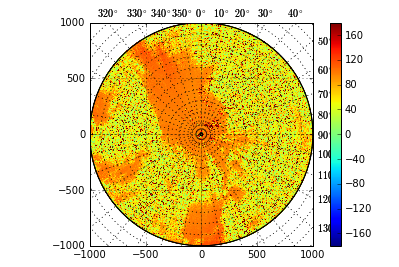

In [119]:
_data = PHIDP.copy()
_r = np.arange(0, _data.shape[1])
_az = np.arange(0, _data.shape[0])
# mask data array for better presentation
_mask = np.where(_data <= np.nanmin(_data))
_data[_mask] = np.nan
_ma = np.ma.array(_data, mask=np.isnan(_data))
fig = plt.figure(figsize=(10,8))
ax, pm = wrl.vis.plot_ppi(_ma, refrac=False,vmin=-180, vmax=180, cg=True, cmap='jet')
#plt.imshow(Z_boxpol)
cb = plt.colorbar(pm, ax=ax)
plt.show()


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less_equal


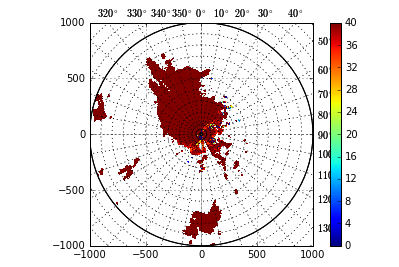

In [120]:
_data = R_corr.copy()
_r = np.arange(0, _data.shape[1])
_az = np.arange(0, _data.shape[0])
# mask data array for better presentation
_mask = np.where(_data <= np.nanmin(_data))
_data[_mask] = np.nan
_ma = np.ma.array(_data, mask=np.isnan(_data))
fig = plt.figure(figsize=(10,8))
ax, pm = wrl.vis.plot_ppi(_ma, refrac=False, cg=True,vmin=0,vmax=40, cmap='jet')
#plt.imshow(Z_boxpol)
cb = plt.colorbar(pm, ax=ax)
plt.show()

/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less_equal


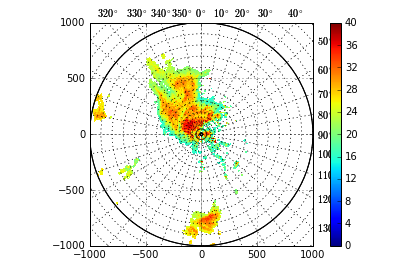

In [121]:
_data = R.copy()
_r = np.arange(0, _data.shape[1])
_az = np.arange(0, _data.shape[0])
# mask data array for better presentation
_mask = np.where(_data <= np.nanmin(_data))
_data[_mask] = np.nan
_ma = np.ma.array(_data, mask=np.isnan(_data))
fig = plt.figure(figsize=(10,8))
ax, pm = wrl.vis.plot_ppi(_ma, refrac=False, cg=True,vmin=0,vmax=40, cmap='jet')
#plt.imshow(Z_boxpol)
cb = plt.colorbar(pm, ax=ax)
plt.show()

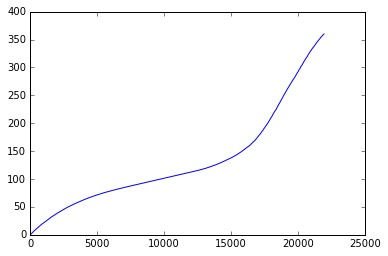

In [122]:
plt.plot(np.unique(PHIDP))

(85, 110)

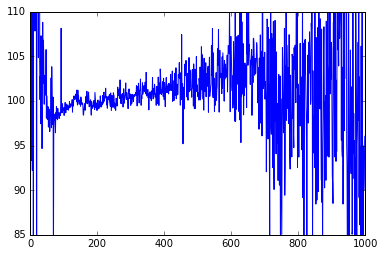

In [128]:
plt.plot(PHIDP[320,:])
plt.ylim(85,110)